https://ml-cheatsheet.readthedocs.io/en/latest/datasets.html

In [248]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_train = pd.read_csv('mnist_train.csv')
data_test = pd.read_csv('mnist_test.csv')

In [249]:
train = np.array(data_train)
m, n = train.shape
np.random.shuffle(train)

In [250]:
test = np.array(data_test)
np.random.shuffle(test)

In [251]:
train = train.T
train_Y = train[0]
train_X = train[1:n] / 255
_,m_train = train_X.shape

In [252]:
test = test.T
test_Y = test[0]
test_X = test[1:n] / 255

In [253]:
def initialize_parameters():
    Wh = np.random.rand(200, 784) - 0.5
    Bh = np.random.rand(200, 1) - 0.5
    Wo = np.random.rand(10, 200) - 0.5
    Bo = np.random.rand(10, 1) - 0.5
    return Wh, Bh, Wo, Bo

In [254]:
def ReLU(z):
    #return np.maximum(0, Z)
    return np.maximum(0.01 * z, z)
    #return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))
    
def ReLU_prime(z):
    #return Z > 0
    return np.where(z > 0, 1.0, 0.01)
    #return 1 - np.power(ReLU(z), 2)

def softmax(Z):
    Z = np.exp(Z) / sum(np.exp(Z))
    return Z

In [255]:
def forward_propagation(Wh, Bh, Wo, Bo, X):
    Zh = Wh.dot(X) + Bh
    Hidden = ReLU(Zh)
    Zo = Wo.dot(Hidden) + Bo
    Out = softmax(Zo)
    return Zh, Hidden, Zo, Out

In [256]:
def one_hot_encoder(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

In [257]:
def back_propagation(Zh, Hidden, Zo, Out, Wh, Wo, X, Y):
    one_hot_Y = one_hot_encoder(Y)
    dZo = Out - one_hot_Y
    dWo = 1 / m * dZo.dot(Hidden.T)
    dBo = 1 / m * np.sum(dZo)
    dZh = Wo.T.dot(dZo) * ReLU_prime(Zh)
    dWh = 1 / m * np.dot(dZh, X.T)
    dBh = 1 / m * np.sum(dZh)
    return dWh, dBh, dWo, dBo

In [258]:
def update_parameters(Wh, Bh, Wo, Bo, dWh, dBh, dWo, dBo, alpha):
    Wh = Wh - alpha * dWh
    Bh = Bh - alpha * dBh    
    Wo = Wo - alpha * dWo  
    Bo = Bo - alpha * dBo    
    return Wh, Bh, Wo, Bo

In [259]:
def get_predictions(Out):
    return np.argmax(Out, 0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

In [266]:
def gradient_descent_optimization(X, Y, alpha, epochs):
    Wh, Bh, Wo, Bo = initialize_parameters()
    Ep = []
    Ac = []
    for epoch in range(epochs):
        Zh, Hidden, Zo, Out = forward_propagation(Wh, Bh, Wo, Bo, X)
        dWh, dBh, dWo, dBo = back_propagation(Zh, Hidden, Zo, Out, Wh, Wo, X, Y)
        Wh, Bh, Wo, Bo = update_parameters(Wh, Bh, Wo, Bo, dWh, dBh, dWo, dBo, alpha)
        if epoch % 100 == 0:
            predictions = get_predictions(Out)
            accuracy = get_accuracy(predictions, Y)
            print(f"Epoch: {epoch} -> Accuracy: {accuracy*100:.2f} %")
            Ep.append(epoch)
            Ac.append(accuracy*100)
            plt.plot(Ep, Ac)
            plt.xlabel("Epoch")
            plt.ylabel("Accuracy (%)")
    return Wh, Bh, Wo, Bo

In [261]:
def make_predictions(X, Wh, Bh, Wo, Bo):
    _, _, _, Out = forward_propagation(Wh, Bh, Wo, Bo, X)
    predictions = get_predictions(Out)
    return predictions

Epoch: 0 -> Accuracy: 15.12 %
Epoch: 100 -> Accuracy: 47.68 %
Epoch: 200 -> Accuracy: 61.94 %
Epoch: 300 -> Accuracy: 68.24 %
Epoch: 400 -> Accuracy: 72.20 %
Epoch: 500 -> Accuracy: 74.82 %
Epoch: 600 -> Accuracy: 76.83 %
Epoch: 700 -> Accuracy: 78.35 %
Epoch: 800 -> Accuracy: 79.56 %
Epoch: 900 -> Accuracy: 80.50 %
Epoch: 1000 -> Accuracy: 81.44 %
Epoch: 1100 -> Accuracy: 82.16 %
Epoch: 1200 -> Accuracy: 82.78 %
Epoch: 1300 -> Accuracy: 83.32 %
Epoch: 1400 -> Accuracy: 83.78 %
Epoch: 1500 -> Accuracy: 84.20 %
Epoch: 1600 -> Accuracy: 84.59 %
Epoch: 1700 -> Accuracy: 84.96 %
Epoch: 1800 -> Accuracy: 85.30 %
Epoch: 1900 -> Accuracy: 85.57 %
Epoch: 2000 -> Accuracy: 85.86 %
Epoch: 2100 -> Accuracy: 86.10 %
Epoch: 2200 -> Accuracy: 86.29 %
Epoch: 2300 -> Accuracy: 86.51 %
Epoch: 2400 -> Accuracy: 86.72 %
Epoch: 2500 -> Accuracy: 86.93 %
Epoch: 2600 -> Accuracy: 87.14 %
Epoch: 2700 -> Accuracy: 87.32 %
Epoch: 2800 -> Accuracy: 87.49 %
Epoch: 2900 -> Accuracy: 87.67 %
Epoch: 3000 -> Accurac

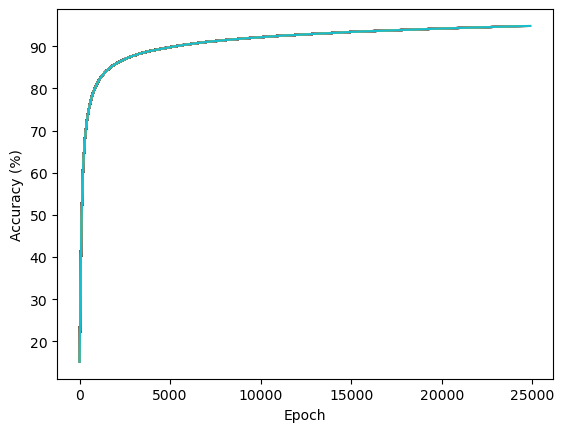

In [267]:
Wh, Bh, Wo, Bo = gradient_descent_optimization(train_X, train_Y, 0.01, 25000)

In [269]:
Model_Test = make_predictions(test_X, Wh, Bh, Wo, Bo)
Acc = get_accuracy(Model_Test, test_Y)*100
print(f"Test Set Accuracy: {Acc:.2f} %")

Test Set Accuracy: 94.39 %
